In [183]:
## utils
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import math
from scipy.stats import pointbiserialr

sns.set_style('white')

## impute
from sklearn.impute import SimpleImputer

## one-hot encoding and scaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, QuantileTransformer

## column transformer
from sklearn.compose import make_column_transformer

## pipeline
from sklearn.pipeline import make_pipeline

## train test split
from sklearn.model_selection import train_test_split

## models - machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## models -- deep learning
import keras

# Titanic Challenge
___

The main purpose of this challenge is to introduce users to their first classification problem. Using the data science process we will:

1. Business Understanding
   
2. Data Understanding

3. Data preparation

4. Modeling

5. Evaluation

6. Submition

#### Business Understanding
___

Hypothetical situation:

I was just hired for a data scientist job at a huge naval construction company. The company is called 'Iceberg' and they're going to make a real life functioning Titanic replica, my boss asked me to find the data from the original Titanic and usa machine learning to help him prepare for the worst. The main question was :

> "If our replica falls into the same situation as the original titanic, is there any way to predict who is going to survive?".

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of April 15, 1912 after striking an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking one of modern history's deadliest peacetime commercial marine disasters ... The final survivor of the sinking, Millvina Dean, aged two months at the time, died in 2009 at the age of 97 [1].

[1] https://en.wikipedia.org/wiki/RMS_Titanic

#### Reading the data
___

In [243]:
## reading the train and test data

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

#### Exploring the data
___

 - dependent variable : 'Survived'
 - indepent variables : 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'

In [185]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [186]:
train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

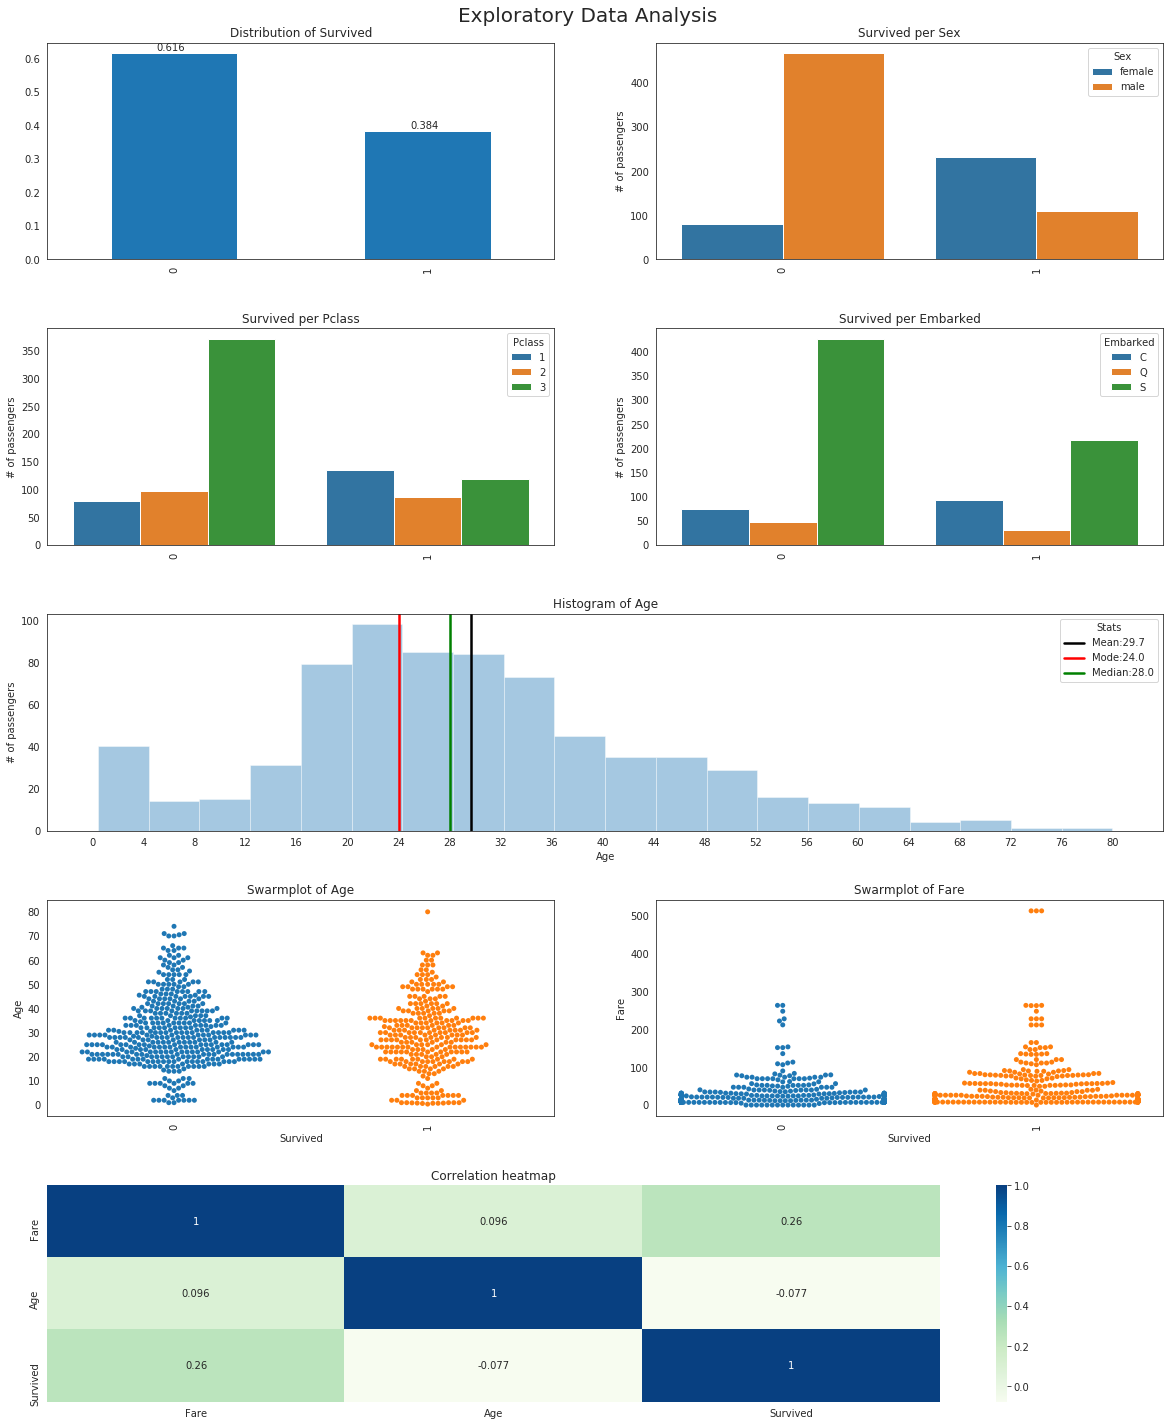

In [187]:
# defining the canvas and the subplots

fig = plt.figure(figsize=(20,25))
fig.suptitle('Exploratory Data Analysis',y=0.9,fontsize=20)
grid = plt.GridSpec(5,2, wspace= 0.2,hspace=0.32)

ax0 = plt.subplot(grid[0,0])
ax1 = plt.subplot(grid[0,1])
ax2 = plt.subplot(grid[1,0])
ax3 = plt.subplot(grid[1,1])
ax4 = plt.subplot(grid[2,:])
ax5 = plt.subplot(grid[3,0])
ax6 = plt.subplot(grid[3,1])
ax7 = plt.subplot(grid[4,:])



# distribution of survived
data = train.Survived.value_counts(normalize=True)
data.plot(kind='bar',ax=ax0)
ax0.set_title('Distribution of Survived')
ax0.text(x=-0.07,y=data[0]+0.008,s=f'{data[0]:.3f}')
ax0.text(x=0.93,y=data[1]+0.008,s=f'{data[1]:.3f}')



# dist survived per sex
data_sex = train[['PassengerId','Sex','Survived']].groupby(['Sex','Survived'],as_index=False).count()
sns.barplot(x='Survived',y='PassengerId',hue='Sex',data=data_sex,ax=ax1)
ax1.set_title('Survived per Sex')
ax1.set_xticklabels(labels=ax1.get_xticklabels(),rotation='vertical')
ax1.set_xlabel('')
ax1.set_ylabel('# of passengers')



# histogram of ages
data_age = train[train['Age'].notna()].Age
data_age_mean = data_age.mean()
data_age_mode = statistics.mode(data_age)
data_age_median = data_age.median()
sns.distplot(data_age,ax=ax4,kde=False)

ax4.set_ylabel('# of passengers')
ax4.set_title('Histogram of Age')
ax4.axvline(data_age_mean,ls='-',lw=2.5,c='black')
ax4.axvline(data_age_mode,ls='-',lw=2.5,c='red')
ax4.axvline(data_age_median,ls='-',lw=2.5,c='green')
ax4.legend((f'Mean:{data_age_mean:.1f}',f'Mode:{data_age_mode:.1f}',f'Median:{data_age_median:.1f}'),title='Stats')
ax4.set_xticks(range(0,84,4))



# distribution of embarked
data_embarked = train[['PassengerId','Embarked','Survived']].groupby(['Embarked','Survived'],as_index=False).count()
sns.barplot(x='Survived',y='PassengerId',hue='Embarked',data=data_embarked,ax=ax3)
ax3.set_title('Survived per Embarked')
ax3.set_xticklabels(labels=ax3.get_xticklabels(),rotation='vertical')
ax3.set_xlabel('')
ax3.set_ylabel('# of passengers');



# distribution of embarked
data_class = train[['PassengerId','Pclass','Survived']].groupby(['Pclass','Survived'],as_index=False).count()
sns.barplot(x='Survived',y='PassengerId',hue='Pclass',data=data_class,ax=ax2)
ax2.set_title('Survived per Pclass')
ax2.set_xticklabels(labels=ax2.get_xticklabels(),rotation='vertical')
ax2.set_xlabel('')
ax2.set_ylabel('# of passengers');



# swarmplot of fare
sns.swarmplot(y=train.Fare,x=train.Survived,ax=ax6)
ax6.set_title('Swarmplot of Fare');
ax6.set_xticklabels(labels=ax6.get_xticklabels(),rotation='vertical')


# swarmplot of age
sns.swarmplot(y=train.Age,x=train.Survived,ax=ax5)
ax5.set_title('Swarmplot of Age');
ax5.set_xticklabels(labels=ax6.get_xticklabels(),rotation='vertical')


# heatmap correlation of Fare,Survived and Age
sns.heatmap(train[['Fare','Age','Survived']].corr(),cmap='GnBu',annot=True,ax=ax7,)
ax7.set_title('Correlation heatmap');

In [188]:
## verifying the number of null values

train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Data preparation
___
- Deal with null values
- Remove unused columns
- Feature engineering
- Feature Scaling
- Feature Encoding
 
Strategy: define pipelines and functions to automate the model evaluation phase

In [190]:
def inputer_age(dataset):
    simple = SimpleImputer(missing_values=np.nan,strategy='mean')
    dataset['Age'] = simple.fit_transform(dataset[['Age']])
    return dataset

def inputer_embarked(dataset):
    simple = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    dataset['Embarked'] = simple.fit_transform(dataset[['Embarked']])
    return dataset

def inputer_fare(dataset):
    simple = SimpleImputer(missing_values=np.nan,strategy='mean')
    dataset['Fare'] = simple.fit_transform(dataset[['Fare']])
    return dataset

def deal(dataset):
    dataset.drop(['Cabin','Ticket','PassengerId','Name'],axis=1,inplace=True)
    inputer_age(dataset)
    inputer_embarked(dataset)
    inputer_fare(dataset)
    return dataset

In [191]:
train = deal(train)

In [192]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [193]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [194]:
'''def title(value):
    try:
        return re.search('Mr\.|Ms\.|Rev\.|Miss\.|Mrs\.|Don\.|Sir\.|Master\.|Dr\.|Mme\.|Capt\.|Col\.|Major\.|Countess\.|Lady\.|Mlle\.|Jonkheer\.',value).group(0)
    except:
        print(f'Found : {value}')
        return np.nan'''
    
def above_expectancy(value):
    if value > 54:
        return 1
    else:
        return 0

def how_above(value):
    return value - 54
    
def time_of_life(df):
    df['time_of_life'] = pd.cut(df['Age'],bins=[0,13.5,27,40.5,df['Age'].max()],labels=['child','young','adult','senior'])
    
def family_size(df):
    df['family_size'] = df['SibSp'] + df['Parch']
    
def quantile_fare_cut(df):
    df['fare_cut'] = pd.qcut(df['Fare'],q=5,labels=['very low','low','medium','high','very high'])

def feature_engineering(dataset):
    #dataset['Name'] = dataset['Name'].apply(title)
    dataset['above'] = dataset['Age'].apply(above_expectancy)
    dataset['how_above'] = dataset['Age'].apply(how_above)
    time_of_life(dataset)
    family_size(dataset)
    quantile_fare_cut(dataset)
    return dataset

In [195]:
train = feature_engineering(train)

In [196]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,above,how_above,time_of_life,family_size,fare_cut
0,0,3,male,22.0,1,0,7.2500,S,0,-32.0,young,1,very low
1,1,1,female,38.0,1,0,71.2833,C,0,-16.0,adult,1,very high
2,1,3,female,26.0,0,0,7.9250,S,0,-28.0,young,0,low
3,1,1,female,35.0,1,0,53.1000,S,0,-19.0,adult,1,very high
4,0,3,male,35.0,0,0,8.0500,S,0,-19.0,adult,0,low


In [197]:
train_num = train[['Age','SibSp','Parch','Fare','how_above','family_size']]
transf_min = QuantileTransformer(n_quantiles=20,output_distribution='normal')
train_df_num = pd.DataFrame(transf_min.fit_transform(train_num))

In [199]:
train_cat = train[['Pclass','Sex','Embarked','above','time_of_life','fare_cut']]
ohe = OneHotEncoder(sparse=False)
train_df_cat = pd.DataFrame(ohe.fit_transform(train_cat),columns=ohe.get_feature_names())

In [200]:
x = pd.concat([train_df_num,train_df_cat],axis=1,sort=False).values
y = train['Survived'].values

In [209]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

#### Modeling
___
- LogisticRegression
- RandomForestClassifier
- SVC

In [210]:
logreg = LogisticRegression(max_iter=1000,solver='lbfgs')
rf = RandomForestClassifier(max_depth=12,n_estimators=1500)
svc = SVC(degree=4,gamma='auto')

In [211]:
logreg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [212]:
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [213]:
svc.fit(x_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [214]:
logreg.score(x_test,y_test)

0.7937219730941704

In [215]:
rf.score(x_test,y_test)

0.8295964125560538

In [216]:
svc.score(x_test,y_test)

0.8026905829596412

In [219]:
from sklearn.model_selection import GridSearchCV

In [223]:
param_grid = {'n_estimators':[100,200,300,400,500],
             'min_samples_split':[2,3,4,5,6,7,8,9,10],
             'min_samples_leaf':[2,5,10],
             'max_depth':[5,10,15,20,25]}

grid = GridSearchCV(rf,param_grid,cv=5)

In [224]:
grid.fit(x,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=12,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1500, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [233]:
grid.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 300}

In [234]:
grid.best_score_

0.8361391694725028

In [235]:
rf_grid = grid.best_estimator_

In [244]:
test = deal(test)

In [245]:
test = feature_engineering(test)

In [247]:
test_num = test[['Age','SibSp','Parch','Fare','how_above','family_size']]
transf_min = QuantileTransformer(n_quantiles=20,output_distribution='normal')
test_df_num = pd.DataFrame(transf_min.fit_transform(test_num))

In [248]:
test_cat = test[['Pclass','Sex','Embarked','above','time_of_life','fare_cut']]
ohe = OneHotEncoder(sparse=False)
test_df_cat = pd.DataFrame(ohe.fit_transform(test_cat),columns=ohe.get_feature_names())

In [256]:
x_final_test = pd.concat([test_df_num,test_df_cat],axis=1,sort=False).values

In [261]:
submission = pd.read_csv('../data/test.csv')
submission['Survived'] = rf_grid.predict(x_final_test)

In [264]:
submission[['PassengerId','Survived']].to_csv('submission.csv',index=False)